In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import numpy as np
from pprint import pprint
import pathlib as pl
import torchaudio
import whisper
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import Audio

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import (
    LlamaTokenizer,
    MistralConfig,
    MistralForCausalLM,
)
import torch
from torch.utils.data import DataLoader
import pathlib as pl

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig

import torch
torch.backends.cuda.matmul.allow_tf32 = True

from src2.voixdb import util
from src2.voixdb.util import *
from src2.voixdb.dataset.music_caps import (
    MusicCapsDataset,
    load_csv,
)
from src2.voixdb.model import Model, TunableWhisperAudioEncoder, load_llm
from src2.voixdb.train import Trainer
from src2.voixdb.train_cfg import TrainerCfg


In [3]:
# !pip install datasets

In [4]:
# import whisper

# import torch
# from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
# from datasets import load_dataset


# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# model_id = "openai/whisper-large-v3"

# model = AutoModelForSpeechSeq2Seq.from_pretrained(
#     model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
# )
# model.to(device)

In [5]:
# from tqdm import tqdm
# with torch.no_grad():
#     with torch.amp.autocast(device_type="cuda",dtype=torch.float16):
#             [audio_encoder(util.load_audio_mels(entry["file"]).cuda()).cpu() for entry in tqdm(train_entries)]

In [6]:
import numpy as np
import random
import os
import torch

# Set seed for everything
seed = 1337
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [7]:
# Access the values of the arguments
tr_cfg = TrainerCfg(
    epoch=1,
    model_save_freq=1,
    device="cuda:0",
    model_out_dir="/root/out-model",
)

stage = "proj" # vs. "peft"
use_lora_projection = True # should the projection be a lora or a full rank matrix?
lr_default = 3e-3#0.5e-4
bs = 2

run_num = 9

class DummyEncoder(nn.Module):
    a=1
whisper_encoder = None#DummyEncoder() # set to None to auto-load it.

audio_encoder = TunableWhisperAudioEncoder(audio_encoder=whisper_encoder,use_lora=use_lora_projection) # it's not None, but I don't wanna load a heavy encoder
if stage == "peft":
    audio_encoder.proj.load_state_dict(torch.load("model_best_save6.pth"))
    for param in audio_encoder.proj.parameters():
        # param.requires_grad = False
        pass

audio_encoder.to(tr_cfg.device)

tokenizer,llm = load_llm()
model = Model(audio_encoder.to(torch.bfloat16), llm)

from peft import get_peft_model, prepare_model_for_int8_training,LoraConfig
if stage == "peft":

    # PEFT config
    lora_alpha = 32
    lora_dropout = 0.1
    lora_r = 16
    peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        r=lora_r,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["k_proj", "q_proj", "v_proj", "up_proj", "down_proj", "gate_proj"]
    )
    model.llm = get_peft_model(model.llm, peft_config)

# print fraction of trainable params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
fraction_trainable = trainable_params / total_params
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Fraction of parameters that are trainable: {fraction_trainable:.2%}")

entries = load_csv(load_raw=False)
train_size = int(len(entries) * 0.95)
train_entries = entries[:train_size]
eval_entries = entries[train_size:]

max_length = 400

embed_tokens = llm.model.embed_tokens
torch.save(embed_tokens.state_dict(),"embed.pt")
raw_embedding = nn.Embedding(embed_tokens.num_embeddings,embed_tokens.embedding_dim)
raw_embedding.load_state_dict(embed_tokens.state_dict())
raw_embedding.cpu()

eval_ds = MusicCapsDataset(eval_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="eval-audio")
eval_dl = DataLoader(eval_ds, batch_size=bs, shuffle=True, num_workers=6)

train_ds = MusicCapsDataset(train_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="train-audio")
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=12)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


loading from pretrained


Error during conversion: ValueError('Queue is full! Please try again.')


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded from pretrained
Total parameters: 4393074304
Trainable parameters: 5937792
Fraction of parameters that are trainable: 0.14%


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# counts, bins = np.histogram(list(train_ds.raw_sizes))
# plt.stairs(counts, bins)

In [9]:
# row = train_ds[0]
# row['input_embeds_raw'][:,0]

In [10]:
# verify model weight
from collections import Counter
pbytype = Counter()
for name, p in (model.named_parameters()):
    if torch.isinf(p).any() or torch.isnan(p).any():
        print(name, p)
        raise ValueError("invalid weight")
    else:
        pbytype[p.dtype] += 1
print("OK", pbytype)

OK Counter({torch.bfloat16: 493, torch.uint8: 224, torch.float16: 67})


In [11]:
# means = []
# stds = []
# norms = []
# for name, p in (model.audio_encoder.audio_encoder.named_parameters()):
#     if p.dim() == 2:
#         print(p.dtype)
#         print(p.max().item(), p.min().item())

#         means.append(p.mean().item())
#         stds.append(p.std().item())
#         norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))
        
# plt.hist(means, bins=100, color='blue', alpha=0.7)

In [12]:
# norms = []
# means = []
# stds = []

# for name, p in (model.audio_encoder.proj.named_parameters()):
#     print(p.dtype)
#     print(p.max().item(), p.min().item())
#     means.append(p.mean().item())
#     stds.append(p.std().item())
#     norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))

# plt.hist(means, bins=100, color='red', alpha=0.7)

In [13]:
@torch.no_grad
def sampler(input_ids):
    outputs = []
    for _ in range(50):
        inputs_embeds = model.llm.model.embed_tokens(input_ids)
        res = model.llm(inputs_embeds=inputs_embeds)
        sampled = torch.multinomial(res.logits[:,-1,:].softmax(dim=-1), 1)# .to(device)
        input_ids = torch.cat((input_ids, sampled), dim=-1)
    return input_ids
        

In [14]:
# tokenizer.decode(sampler(tokenizer("tell me a story", return_tensors="pt").input_ids.to(tr_cfg.device))[0])

In [15]:
import torch.optim as optim

adam_beta1 = 0.9
adama_beta2 = 0.999
adam_eps = 1e-8

# TODO: experiment with AdamW
optimizer = optim.Adam(
    [*model.parameters(),nn.Parameter(torch.tensor(1.0))],
    lr=lr_default,
    betas=(adam_beta1, adama_beta2),
    eps=adam_eps,
)
datagen = iter(train_dl)
device = tr_cfg.device
uds = []
losses = []

In [16]:
# from src2.voixdb.dataset.music_caps import MusicCapsDataset
# train_ds = MusicCapsDataset(train_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="train-audio")
# train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1)
# datagen = iter(train_dl)

# from time import perf_counter
# start_time = perf_counter()
# for i in range(3):
#     b = next(datagen)

# time_per_iter = (perf_counter() - start_time) / 20

# time_per_iter
# # raise 1

In [17]:
{k:v.shape for k,v in train_ds[0].items() if torch.is_tensor(v)}

{'attention_mask': torch.Size([400]),
 'input_embeds_raw': torch.Size([400, 4096]),
 'input_ids_raw': torch.Size([400]),
 'audio_embeds_raw': torch.Size([2000, 1280]),
 'audio_tokens_start': torch.Size([]),
 'audio_tokens_end': torch.Size([]),
 'cap_tokens_start': torch.Size([]),
 'n_audio_embeds': torch.Size([])}

In [18]:
inputs_embeds = None
attention_mask = None
batch = None

def fwd(self, _batch):
    global inputs_embeds,attention_mask,batch
    batch = _batch
    attention_mask = batch["attention_mask"]
    inputs_embeds = batch["input_embeds_raw"].clone()
    audio_embeds_raw = batch["audio_embeds_raw"]

    audio_start = batch["audio_tokens_start"]
    audio_end = batch["audio_tokens_end"]

    n_audio_embeds = batch["n_audio_embeds"]

    # print({k:v.shape for k,v in batch.items()})

    # un-pad and project the audio embeddings separately
    audio_embeds = torch.stack([self.audio_encoder.proj(audio_embeds_raw[i,-n_audio_embeds[i]:]) for i in range(len(n_audio_embeds))])
    assert audio_embeds.shape[1] == 250,f"shape is {audio_embeds.shape}"

    N,*_ = audio_embeds.shape
    for i in range(N):
        # print(inputs_embeds.shape,audio_start[i],audio_end[i],audio_embeds.shape,audio_embeds_raw.shape)
        # print("curr_embeds",inputs_embeds[i,audio_start[i]:audio_end[i]])
        inputs_embeds[i,audio_start[i]:audio_end[i]] = audio_embeds[i]
    
    # print('cap_embeds', cap_embeds.mean(dim=1), cap_embeds.std(dim=1))
    mout = self.llm(
        inputs_embeds=inputs_embeds,
        # output_attentions=True,
        # output_hidden_states=True,
        attention_mask=attention_mask,
        # use_cache=False,
    )

    return mout, audio_embeds.shape[1]

In [19]:
local_batch = next(datagen)
batch = {
    k: v.to(device)
    for k, v in local_batch.items()
    if not k.startswith("_")
}
with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
    fwd(model,batch)
# raise 1

In [20]:
attention_mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.,

In [21]:
inputs_embeds[:,:,0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -4.5776e-03,  6.2180e-04, -9.9182e-04, -1.0910e-03,  1.7071e-04,
          2.0142e-03,  3.7193e-04,  3.7384e-04, -7.5073e-03, -2.2697e-04,
         -6.3705e-04,  1.8997e-03,  1.4725e-03,  8.7738e-04,  2.0264e-02,
          6.2180e-04, -5.8365e-04, -1.0910e-03,  1.7071e-04,  3.0975e-03,
          3.0327e-04,  1.9531e-03, -6.3324e-04,  3.0327e-04,  6.0272e-04,
         -1.0757e-03, -6.9580e-01, -6.0205e-01, -1.9951e+00, -5.9906e-02,
          1.8323e-01, -1.3887e+00, -2.3438e+00, -1.1533e+00, -2.0996e+00,
         -1.3916e+00, -2.2344e+00, -1.5371e+00, -1.0205e+00, -7.4951e-01,
         -4.1748e-01, -1.9760e-02, -1.6230e+00,  9.4043e-01, -8.2910e-01,
          3.7769e-01,  1.3789e+00,  5.0977e-01,  6.1066e-02, -5.2783e-01,
          8.7744e-01,  2.0215e+00,  1.

In [22]:
batch["audio_embeds_raw"][:,-1500:]

tensor([[[-5.4590e-01, -3.9722e-01,  9.3323e-02,  ...,  6.6992e-01,
          -8.8574e-01, -5.2246e-01],
         [-3.0347e-01, -1.0977e+00,  5.4590e-01,  ..., -1.8616e-01,
          -4.0942e-01, -2.1655e-01],
         [-2.9346e-01, -6.3525e-01,  1.2744e-01,  ..., -3.9478e-01,
          -1.7710e-03,  4.1919e-01],
         ...,
         [-4.9414e-01, -6.9922e-01, -3.8745e-01,  ..., -1.2903e-01,
           2.9248e-01, -4.6118e-01],
         [-3.9746e-01, -4.5128e-03, -4.4482e-01,  ...,  3.1714e-01,
           6.3538e-02, -1.8477e+00],
         [-1.6040e-01,  5.5127e-01, -3.9746e-01,  ...,  4.2188e-01,
           3.3423e-01, -7.7588e-01]],

        [[-3.8818e-01, -5.0586e-01,  5.0439e-01,  ..., -9.2285e-01,
           1.9568e-01,  1.8628e-01],
         [-3.9404e-01, -1.6089e-01, -4.4653e-01,  ...,  3.2251e-01,
           3.4277e-01, -2.9395e-01],
         [-4.0430e-01,  7.9803e-03, -4.2139e-01,  ...,  2.6343e-01,
           5.8691e-01,  1.1169e-01],
         ...,
         [-4.3652e-01, -4

In [23]:
with torch.no_grad():
    with torch.amp.autocast(device_type="cuda",dtype=torch.float16):
        a=audio_encoder.audio_encoder(util.load_audio_mels(train_ds.entries[0]["file"]).cuda())
a

tensor([[[-0.4104,  0.0649,  0.5522,  ..., -0.1167, -0.3240, -0.6045],
         [ 0.1138, -0.9551, -0.2742,  ..., -0.4602, -0.3120, -0.3083],
         [ 0.0380, -0.3933, -0.4968,  ..., -0.1611, -0.2249, -0.3965],
         ...,
         [-0.4922, -0.2446, -0.2267,  ...,  0.0430, -0.1564, -1.2529],
         [-0.3904,  0.3357, -0.4678,  ...,  0.2822, -0.4429, -1.5586],
         [-0.1785,  0.7549, -0.4580,  ...,  0.3855,  0.0160, -0.4167]]],
       device='cuda:0', dtype=torch.float16)

In [24]:
# torch.sum(batch["attention_mask"][1] != 0)

In [25]:
# train_ds.raw_audio_embeds[0].shape

In [26]:
# targets[0]
# tokenizer.decode(targets[0,-84:])
# tokenizer.decode(torch.max(logits[0,-84:],dim=-1).indices)
# with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
#     b = model.audio_encoder.proj(batch["audio_embeds_raw"][0,-batch["n_audio_embeds"][0]:])
# b
# print(batch["n_audio_embeds"][0])
# print(torch.sum(batch["audio_embeds_raw"][0,:,0]!=0),batch["audio_embeds_raw"].shape)



In [27]:
def get_loss(local_batch):
    # Transfer to GPU
    batch = {
        k: v.to(device)
        for k, v in local_batch.items()
        if not k.startswith("_")
    }
    # compute
    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        mout, audio_seq = fwd(model, batch)

    targets = batch["input_ids_raw"][:]
    target_idxes = torch.arange(max_length,device=targets.device)[None]

    # remove the last output
    logits = mout.logits
    logits_start = batch["cap_tokens_start"].to(targets.device)

    # print()
    targets = torch.masked_fill(targets,target_idxes < logits_start[:,None],-100)[:,1:].long()
    
    # remove the prompt and audio seq from logits
    # calculation; additionally, remove the final item
    logits = logits[:, :-1, :].contiguous().to(targets.device)

    # logits = logits[:,-20:]
    # targets = targets[:,-20:]
    assert logits.shape[:2] == targets.shape[:2], f"shape is {logits.shape} and {targets.shape}"
    # print(logits.shape,targets.shape)

    loss = nn.functional.cross_entropy(
        logits.view(-1, logits.shape[-1]), targets.view(-1)
    )

    return loss


In [28]:
from tqdm import tqdm
# taken from https://gist.github.com/Tony-Y/03e47588bae2e2bfd69815d046d994ec
import pytorch_warmup as warmup

epochs = 50
steps_per_epoch = len(train_dl)
warmup_period = 1000
num_steps = steps_per_epoch * epochs - warmup_period
t0 = num_steps // 3 # first cosine anneal

lr_min = 3e-5
max_step = t0 * 3 + warmup_period

lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=t0, T_mult=1, eta_min=lr_min)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)

best_loss = 1e9

for _ in range(50):
    model.train()
    for i, local_batch in enumerate(train_dl):
        loss = get_loss(local_batch)

        # required to access grad on non leaf nodes
        for p in model.audio_encoder.proj.parameters():
            if p.requires_grad:
                p.retain_grad()
        
        # print("lossed")
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


        with warmup_scheduler.dampening():
            if warmup_scheduler.last_step + 1 >= warmup_period:
                lr_scheduler.step()
        if warmup_scheduler.last_step + 1 >= max_step:
            break

        # print("backwarded")
        
        with torch.no_grad():
            ud = []
            for name, p in model.audio_encoder.proj.named_parameters():
                if not p.requires_grad or p.grad is None:
                    continue
                # if i % 10 == 0:
                #    print(name, p.grad.mean().item(), p.grad.std().item())
                ud.append(((lr_default*p.grad).std() / p.data.std()).log10().item())
            uds.append(ud)
            
        
        losses.append(loss.detach().cpu())
        del loss
        if i % 500 == 0:
            eval_losses = []
            with torch.no_grad():
                model.eval()
                for local_batch in tqdm(eval_dl):
                    eval_loss = get_loss(local_batch)
                    eval_losses.append(eval_loss.cpu())
            print(f"{i}: train={np.mean(losses):.4f} eval={np.mean(eval_losses):.4f}")
            if np.mean(eval_losses) < best_loss:
                best_loss = np.mean(eval_losses)
                if stage == "proj":
                    torch.save(
                        model.audio_encoder.proj.state_dict(),
                        f"model_best_save{run_num}.pth",
                    )
                elif stage == "peft":
                    # save peft params
                    filt_state_dict = {k:v for k,v in model.llm.state_dict().items() if "lora" in k}
                    torch.save(filt_state_dict, f"lora_best_save{run_num}.pth")
            del eval_losses


100%|██████████| 124/124 [00:30<00:00,  4.05it/s]


0: train=8.0473 eval=8.2173


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


500: train=3.3544 eval=2.3276


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


1000: train=2.7974 eval=2.1213


100%|██████████| 124/124 [00:30<00:00,  4.02it/s]


1500: train=2.5689 eval=2.0063


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


2000: train=2.4382 eval=1.9546


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


0: train=2.3744 eval=1.9331


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


500: train=2.3020 eval=1.9126


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


1000: train=2.2444 eval=1.8703


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


1500: train=2.2013 eval=1.8511


100%|██████████| 124/124 [00:30<00:00,  4.05it/s]


2000: train=2.1646 eval=1.8478


100%|██████████| 124/124 [00:30<00:00,  4.00it/s]


0: train=2.1424 eval=1.8305


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


500: train=2.1107 eval=1.8139


100%|██████████| 124/124 [00:30<00:00,  4.02it/s]


1000: train=2.0858 eval=1.7986


100%|██████████| 124/124 [00:30<00:00,  4.05it/s]


1500: train=2.0648 eval=1.8076


100%|██████████| 124/124 [00:30<00:00,  4.05it/s]


2000: train=2.0468 eval=1.7807


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


0: train=2.0360 eval=1.7774


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


500: train=2.0200 eval=1.7840


100%|██████████| 124/124 [00:30<00:00,  4.05it/s]


1000: train=2.0046 eval=1.7714


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


1500: train=1.9912 eval=1.7655


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


2000: train=1.9787 eval=1.7614


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


0: train=1.9701 eval=1.7552


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


500: train=1.9580 eval=1.7587


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


1000: train=1.9484 eval=1.7729


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


1500: train=1.9390 eval=1.7388


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


2000: train=1.9287 eval=1.7327


100%|██████████| 124/124 [00:30<00:00,  4.02it/s]


0: train=1.9229 eval=1.7302


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


500: train=1.9140 eval=1.7464


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


1000: train=1.9056 eval=1.7413


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


1500: train=1.8976 eval=1.7266


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


2000: train=1.8910 eval=1.7374


100%|██████████| 124/124 [00:30<00:00,  4.01it/s]


0: train=1.8860 eval=1.7400


100%|██████████| 124/124 [00:30<00:00,  4.00it/s]


500: train=1.8781 eval=1.7347


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


1000: train=1.8711 eval=1.7362


100%|██████████| 124/124 [00:30<00:00,  4.02it/s]


1500: train=1.8651 eval=1.7228


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


2000: train=1.8593 eval=1.7321


100%|██████████| 124/124 [00:30<00:00,  4.00it/s]


0: train=1.8553 eval=1.7300


100%|██████████| 124/124 [00:30<00:00,  4.02it/s]


500: train=1.8487 eval=1.7397


100%|██████████| 124/124 [00:30<00:00,  4.02it/s]


1000: train=1.8435 eval=1.7296


100%|██████████| 124/124 [00:30<00:00,  4.02it/s]


1500: train=1.8376 eval=1.7370


100%|██████████| 124/124 [00:30<00:00,  4.02it/s]


2000: train=1.8324 eval=1.7124


100%|██████████| 124/124 [00:31<00:00,  4.00it/s]


0: train=1.8286 eval=1.7245


100%|██████████| 124/124 [00:30<00:00,  4.01it/s]


500: train=1.8232 eval=1.7515


100%|██████████| 124/124 [00:30<00:00,  4.03it/s]


1000: train=1.8180 eval=1.7329


100%|██████████| 124/124 [00:30<00:00,  4.04it/s]


1500: train=1.8129 eval=1.7200


100%|██████████| 124/124 [00:31<00:00,  3.99it/s]


2000: train=1.8078 eval=1.7262


100%|██████████| 124/124 [00:30<00:00,  4.00it/s]


0: train=1.8045 eval=1.7297


100%|██████████| 124/124 [00:31<00:00,  4.00it/s]


500: train=1.7996 eval=1.7363


KeyboardInterrupt: 

In [ ]:
# if stage == "peft":
#     model.llm.load_state_dict(torch.load(f"lora_best_save{run_num}.pth"),strict=False)

_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.o_proj.weight', 'base_model.model.model.layers.0.mlp.gate_proj.base_layer.weight', 'base_model.model.model.layers.0.mlp.up_proj.base_layer.weight', 'base_model.model.model.layers.0.mlp.down_proj.base_layer.weight', 'base_model.model.model.layers.0.input_layernorm.weight', 'base_model.model.model.layers.0.post_attention_layernorm.weight', 'base_model.model.model.layers.1.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.1.self_attn.k_proj.base_layer.weight', 'base_model.model.model.layers.1.self_attn.v_proj.base_layer.weight', 'base_model.model.model.layers.1.self_attn.o_proj.weight', 'base_model.model.model.layers.1.mlp.gate_proj.base_layer.we

layer lora_1.weight | weight (128, 1280) | mean -0.000003 | std 4.852295e-03 | grad:data ratio 9.667969e-02
layer lora_1.bias | weight     (128,) | mean +0.000452 | std 7.873535e-03 | grad:data ratio 2.617188e-01
layer lora_2.weight | weight (4096, 128) | mean -0.000001 | std 1.068115e-03 | grad:data ratio 8.728027e-03
layer lora_2.bias | weight    (4096,) | mean -0.000015 | std 9.574890e-04 | grad:data ratio 1.745605e-02
layer ln1.weight | weight    (1280,) | mean -0.000047 | std 3.753662e-03 | grad:data ratio 9.453125e-01
layer ln1.bias | weight    (1280,) | mean +0.000299 | std 5.676270e-03 | grad:data ratio 8.447266e-02


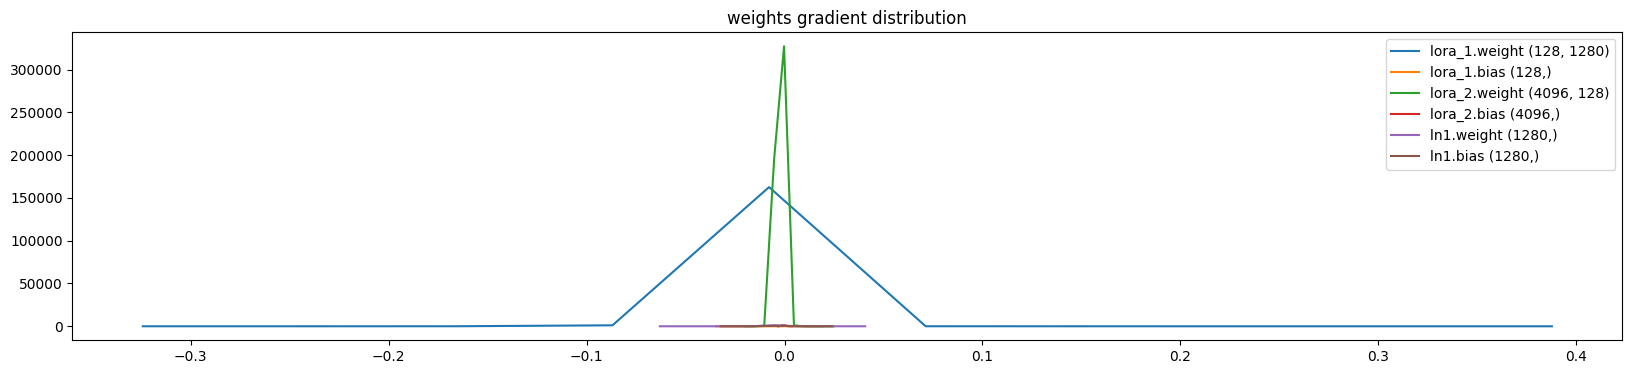

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
parameters = []
for i, l in enumerate([model.audio_encoder.proj]):
    #print('layer', l.__class__)
    for name, p in l.named_parameters():
        t = p.grad
        
        if t is None:
            continue

        print('layer %s | weight %10s | mean %+f | std %e | grad:data ratio %e' % (
            name, tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))

        hy, hx = np.histogram(t.to(torch.float32).cpu().detach().numpy())
        plt.plot(hx[:-1], hy)
        legends.append(f'{name} {tuple(p.shape)}')
            
plt.legend(legends)
plt.title('weights gradient distribution');

Text(0.5, 1.0, 'weight update relative to weight data, log scale')

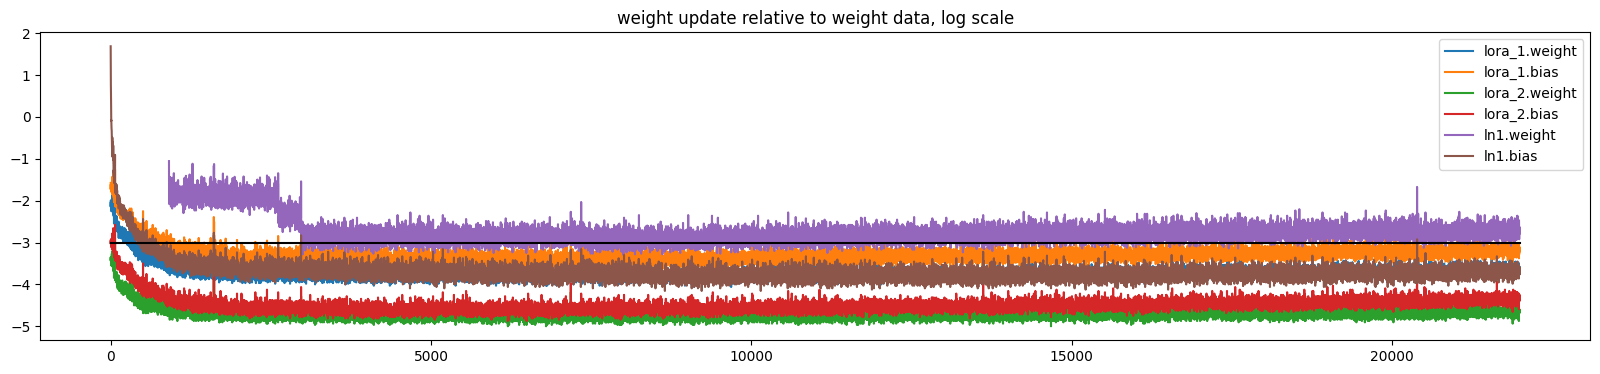

In [30]:
plt.figure(figsize=(20, 4))
legends = []
i = 0
for name, p in (model.audio_encoder.proj.named_parameters()):
    if p.grad is None:
        continue
    
    plt.plot([uds[epoch][i] for epoch in range(len(uds))])
    legends.append(name)

    i += 1
            
plt.plot([0, len(uds)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title("weight update relative to weight data, log scale")


In [31]:
l = torch.tensor(losses)

In [32]:
l[-50:].mean()

tensor(1.6275)

In [33]:
size_to_clip = l.size(0) - (l.size(0) % 100)
ml = l[:size_to_clip].reshape(-1, 100).mean(axis=1)


(0.0, 2.0)

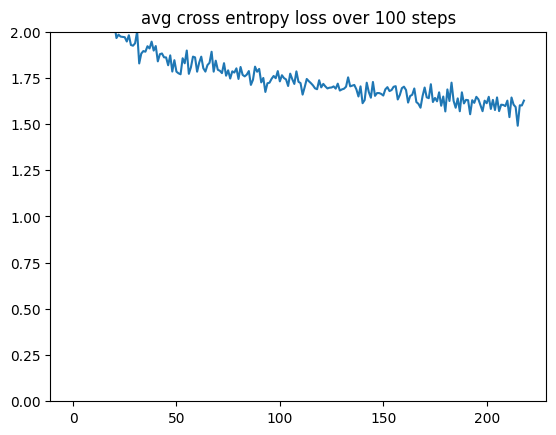

In [34]:
plt.plot(range((ml.shape[0])), ml.numpy())
plt.title("avg cross entropy loss over 100 steps")
plt.ylim(0, 2)

In [35]:
out = f"model_manual_save{run_num}.pth"

torch.save(
    model.audio_encoder.proj.state_dict(),
    out,
)

In [36]:
from src2.voixdb.dataset.music_caps import MusicCapsDataset
eval_ds = MusicCapsDataset(eval_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="eval-audio")
eval_dl = DataLoader(eval_ds, batch_size=1, shuffle=True, num_workers=1)
datagen=iter(eval_dl)

In [37]:
local_batch = next(datagen)
audio_file = local_batch["_id"][0][0]

print(tokenizer.decode(local_batch["input_ids_raw"][0]))
Audio(audio_file)

<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><s> <|im_start|>  system
    You are a helpful AI who follows instruction carefully<|im_end|> <|im_start|>  user
    Describe the sound of the given file<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><u

In [38]:
from src2.voixdb.util import sample_with_audio
print(tokenizer.decode(sample_with_audio(model, llm, tokenizer, prompt_template_fn(), audio_file, iteration=100)[0]))

<s> <|im_start|>  system
    You are a helpful AI who follows instruction carefully<|im_end|> <|im_start|>  user
    Describe the sound of the given file 
    <|im_end|> <|im_start|> assistant
     A solo angle harp is played. The mood is bluesy and free flowing. The technique used resembles that of a theremin in tone and melody and the song sounds raw and homemade as the recording is made with poor fidelity. The song initially starts with a melody being played on a harmonica and then it is filled with feedback. The song is raw and amateur. The song is instrumental and has no percussion. The singer plays the instrument in real time


In [39]:
import torch
import whisper

def prompt_template_fn(prompt="Describe the sound of the given file"):
    system_message = "You are a helpful AI who follows instruction carefully"

    prompt_prefix = f"""<|im_start|>system
    {system_message}<|im_end|>
    <|im_start|>user
    {prompt}"""

    return prompt_prefix


def end_template():
    return """
    <|im_end|>
    <|im_start|>assistant
    """


def load_audio_mels(file):
    audio = whisper.load_audio(file)
    audio = whisper.pad_or_trim(audio)
    audio_mels = whisper.log_mel_spectrogram(audio, n_mels=128)
    audio_mels = audio_mels.unsqueeze(0)
    return audio_mels


def text_2_ids_and_attention_mask(tokenizer, input_txt, truncate=False):
    txt = input_txt
    res = tokenizer(txt, return_tensors="pt")

    if truncate:
        return res.input_ids[:, 1:], res.attention_mask[:, 1:]

    return res.input_ids, res.attention_mask

@torch.no_grad()
def sample_with_audio(model, tokenizer, prompt, audio_file, device="cuda:0", iteration=50):
    audio_mels = load_audio_mels(audio_file).to(device).half()
    end_prompt_ids, end_prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        end_template(),
        truncate=True,
    )
    prompt_ids, prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        prompt,
    )

    prompt_ids = prompt_ids.to(device)
    prompt_attention_mask = prompt_attention_mask.to(device)
    end_prompt_attention_mask = end_prompt_attention_mask.to(device)
    end_prompt_ids = end_prompt_ids.to(device)
    sampled_ids = None

    prompt_embeds = None
    end_prompt_embeds = None
    audio_embeds = None

    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        if audio_embeds is None:
            audio_embeds = model.audio_encoder(audio_mels)
        bs, audio_seq = audio_embeds.shape[:2]
        
        mask_concat_args = [
            prompt_attention_mask,
            torch.ones(bs, audio_seq).to(audio_embeds.device),
            end_prompt_attention_mask,
        ]

        for _ in range(iteration):
            if sampled_ids is not None:
                mask_concat_args.append(torch.ones(bs, sampled_ids.shape[1]).to(audio_embeds.device))
                
            attention_mask = torch.concat(
                tuple(mask_concat_args),
                dim=1,
            )

            if prompt_embeds is None:
                prompt_embeds = model.llm.model.embed_tokens(prompt_ids)
            if end_prompt_embeds is None:
                end_prompt_embeds = model.llm.model.embed_tokens(end_prompt_ids)
                
            sampled_ids_embeds = None
            if sampled_ids is not None:
                sampled_ids_embeds = model.llm.model.embed_tokens(sampled_ids)
                
            embeds_concat_args = [
                prompt_embeds,
                audio_embeds.to(prompt_embeds.dtype),
                end_prompt_embeds,
            ]
            if sampled_ids_embeds is not None:
                embeds_concat_args.append(sampled_ids_embeds)
                
            inputs_embeds = torch.concat(
                tuple(embeds_concat_args),
                dim=1,
            )
    
            mout = model.llm(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
            )
    
            logits = mout.logits
            sampled = torch.multinomial(logits[:, -1, :].softmax(dim=-1), 1)
            
            if sampled_ids is None:
                sampled_ids = sampled
            else:
                sampled_ids = torch.cat((sampled_ids, sampled), dim=-1).to(device)

    # print(prompt_ids.shape)
    # print(end_prompt_ids.shape)
    # print(sampled_ids.shape)
    
    return torch.concat((
        prompt_ids, 
        end_prompt_ids,
        sampled_ids,
    ),dim=-1)
